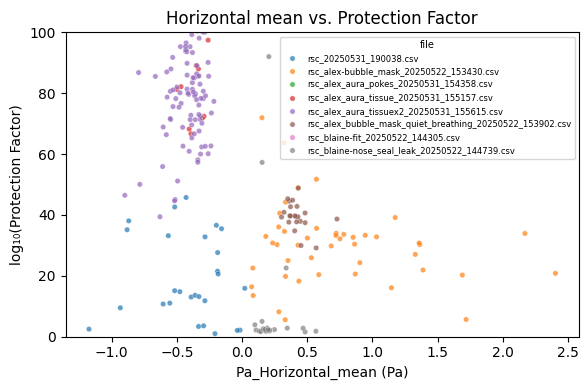

In [7]:
# ⬇️ install once per environment
# !pip install seaborn --quiet

import sqlite3, math, warnings, seaborn as sns, numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = Path("breath_db.sqlite")        # change if needed
TABLE    = "breath_features"              # fallback names checked automatically

# --------------------------------------------------------------------- 1) locate table
with sqlite3.connect(DB_PATH) as conn:
    cur = conn.execute(
        "SELECT name FROM sqlite_master WHERE type='table'")
    tables = {row[0] for row in cur.fetchall()}

if TABLE not in tables:
    # try common variants
    fallback = [t for t in tables if t.startswith("breath_features")]
    if not fallback:
        raise RuntimeError(
            f"No table named 'breath_features*' found in {DB_PATH}. "
            f"Run the feature-extraction script first.")
    TABLE = fallback[0]
    warnings.warn(f"Using table {TABLE!r} instead.")

# --------------------------------------------------------------------- 2) load data
with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql(
        f"SELECT source_file, Pa_Horizontal_mean, protection_factor "
        f"FROM {TABLE} "
        f"WHERE protection_factor IS NOT NULL", conn)

df["logPF"] = df["protection_factor"].clip(lower=1).pipe(np.log10)

# --------------------------------------------------------------------- 3) scatter, one colour per file
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df,
                x="Pa_Horizontal_mean",
                y="protection_factor",
                hue="source_file",
                palette="tab10",   # up to 10 files; seaborn auto-loops thereafter
                s=15, alpha=0.7)

plt.ylim(0, 100)
plt.xlabel("Pa_Horizontal_mean (Pa)")
plt.ylabel("log₁₀(Protection Factor)")
plt.title("Horizontal mean vs. Protection Factor")
plt.legend(title="file", fontsize=6, title_fontsize=7, loc="best")
plt.tight_layout()
plt.show()
